In [1]:
import math, random, time, copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
import csv

In [2]:
def parse_cvrp_file(lines):
    customers = []
    distances = []
    demands = []
    depots = []
    capacity = None

    current_section = None
    for line in lines:
        line = line.strip()
        if line.startswith("CAPACITY"):
            capacity = int(line.split(":")[1].strip())
            continue
        elif line.startswith("NODE_COORD_SECTION"):
            current_section = "customers"
            continue
        elif line.startswith("DEMAND_SECTION"):
            current_section = "demands"
            continue
        elif line.startswith("DEPOT_SECTION"):
            current_section = "depots"
            continue
        elif line == "-1":
            current_section = None
            continue

        if current_section == "customers":
            parts = line.split()
            customers.append([int(parts[0]),int(float(parts[1])),int(float(parts[2]))])
        elif current_section == "demands":
            parts = line.split()
            demands.append([int(parts[0]),int(float(parts[1]))])
        elif current_section == "depots":
            parts = line.split()
            depots.append(int(parts[0]))
    for i in range(len(customers)):
        distances.append([])
        for j in range(len(customers)):
            if i<=j:
                distances[i].append(math.sqrt((customers[i][1]-customers[j][1])**2+(customers[i][2]-customers[j][2])**2))
            else:
                distances[i].append(distances[j][i])

    return customers, distances, demands, capacity, depots  

# Example usage with file reading
# dataset_name = "eilC76.vrp"
dataset_name = "eil51.vrp"
# dataset_name = "eilB101.vrp"    
with open(dataset_name, 'r') as city_data:
    lines = city_data.readlines()

cities, distances, demands, capacity, depots = parse_cvrp_file(lines)

In [190]:
td = sum([sum(d) for d in distances])
td

82686.96050624266

In [3]:
class MTSPGeneticAlgorithm:
    def __init__(self, customers, distances, demands, depots, capacity, num_salesmen, population_size=10, crossover_rate = 0.9, mutation_rate=0.1, max_generations=100):
        self.customers = customers
        self.distances = distances
        self.demands = demands
        self.depots = depots
        self.capacity = capacity
        self.num_salesmen = num_salesmen
        self.population_size = population_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.max_generations = max_generations
        self.population = self.initialize_population()
        self.best_solution = None
        self.best_distance = float('inf')
        self.fitness_history = []

    def initialize_population(self):
        # Initialize population with random solutions
        population = []
        for _ in range(self.population_size):
            solution = self.generate_random_solution()
            population.append(solution)
        return population

    def generate_random_solution(self):
        # Generate a random solution for the mTSP
        solution = []
        unvisited = list(item[0] for item in self.customers)
        unvisited.remove(self.depots[0])
        random.shuffle(unvisited)
        solution = [self.depots[0]] + unvisited + [self.depots[0]]
        return solution

    def calculate_distance(self, solution):
        # Calculate total distance for a solution (same as in Tabu Search)
        total_distance = 0.0
        num_customers_per_salesman = (len(self.customers)-1) // self.num_salesmen
        for i in range(self.num_salesmen):
            start = i * num_customers_per_salesman
            end = (i + 1) * num_customers_per_salesman if i != self.num_salesmen - 1 else len(self.customers)
            total_distance += self.distances[self.depots[0] - 1][solution[start] - 1]
            for j in range(start, end - 1):
                total_distance += self.distances[solution[j] - 1][solution[j + 1] - 1]
            total_distance += self.distances[solution[end - 1] - 1][self.depots[0] - 1]
        return total_distance

    def selection(self):
        # Tournament selection
        tournament_size = 5
        selected_parents = []
        for _ in range(self.population_size):
            tournament = random.sample(self.population, tournament_size)
            best = min(tournament, key=self.calculate_distance)
            selected_parents.append(best)
        return selected_parents

    def crossover(self, parent1, parent2):
        # Ordered crossover to produce two children
        if random.random() < self.crossover_rate:
            start, end = sorted(random.sample(range(len(parent1)), 2))

            # Create first child
            child1 = [None] * len(parent1)
            child1[start:end+1] = parent1[start:end+1]
            child1_remaining = [item for item in parent2 if item not in child1[start:end+1]]
            child1 = child1_remaining[:start] + child1[start:end+1] + child1_remaining[start:]

            # Create second child
            child2 = [None] * len(parent2)
            child2[start:end+1] = parent2[start:end+1]
            child2_remaining = [item for item in parent1 if item not in child2[start:end+1]]
            child2 = child2_remaining[:start] + child2[start:end+1] + child2_remaining[start:]

            return child1, child2
        else:
            return parent1, parent2

    def mutation(self, solution):
        # Swap mutation
        if random.random() < self.mutation_rate:
            idx1, idx2 = random.sample(range(len(solution)), 2)
            solution[idx1], solution[idx2] = solution[idx2], solution[idx1]

    # def evaluate_population(self):
    #     for solution in self.population:
    #         distance = self.calculate_distance(solution)
    #         if distance < self.best_distance:
    #             self.best_distance = distance
    #             self.best_solution = solution
    #         self.fitness_history.append(self.best_distance)

    def search(self):
        for _ in range(self.max_generations):
            # Select parents
            parents = self.selection()
            # Generate next generation
            new_population = []
            for i in range(0, len(parents), 2):
                offspring1, offspring2 = self.crossover(parents[i], parents[i+1])
                new_population.extend([offspring1, offspring2])
            # Apply mutation
            for individual in new_population:
                self.mutation(individual)
            self.population = new_population
            # self.evaluate_population()
            for solution in self.population:
                distance = self.calculate_distance(solution)
                if distance < self.best_distance:
                    self.best_distance = distance
                    self.best_solution = solution
            self.fitness_history.append(self.best_distance)
        return self.best_solution, self.best_distance, self.fitness_history


In [25]:
ga = MTSPGeneticAlgorithm(cities, distances, demands, depots, capacity, 3, population_size=500, crossover_rate = 0.9, mutation_rate=0.1, max_generations=1000)
best_solution, best_distance,fitness_history = ga.search()

In [108]:
ga = MTSPGeneticAlgorithm(cities, distances, demands, depots, capacity, 3, population_size=500, crossover_rate = 0.9, mutation_rate=0.1, max_generations=1000)
best_solution, best_distance,fitness_history = ga.search()
best_distance

622.21738911947

In [29]:
best_distance

519.7277062851023

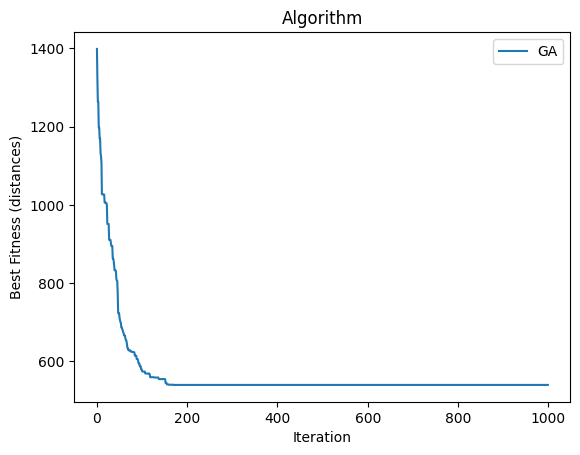

In [27]:
# Plot the convergence curve
plt.plot(fitness_history,label = 'GA')
plt.title('Algorithm')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (distances)')
plt.legend()
plt.show()

In [9]:
ga = MTSPGeneticAlgorithm(cities, distances, demands, depots, capacity, 3, population_size=500, crossover_rate = 0.9, mutation_rate=0.1, max_generations=1000)
best_solution, best_distance,fitness_history = ga.search()

In [10]:
best_distance

523.3893995017489

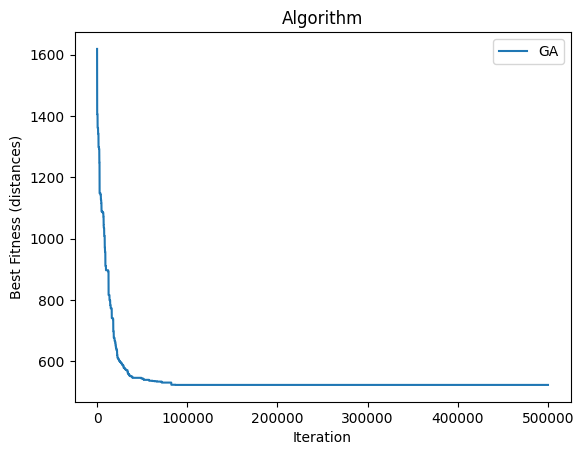

In [11]:
# Plot the convergence curve
plt.plot(fitness_history,label = 'GA')
plt.title('Algorithm')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (distances)')
plt.legend()
plt.show()

In [4]:
class MTSPParticleSwarmOptimization:
    def __init__(self, customers, distances, demands, depots, capacity, num_salesmen, num_particles=30, max_iterations=20):
        self.customers = customers
        self.distances = distances
        self.demands = demands
        self.depots = depots
        self.capacity = capacity
        self.num_salesmen = num_salesmen
        self.num_particles = num_particles
        self.max_iterations = max_iterations
        self.particles = self.initialize_particles()
        self.global_best = self.get_global_best()
        self.velocity = [[random.uniform(-1, 1) for _ in range(len(customers))] for _ in range(num_particles)]
        self.fitness_history = []

    def initialize_particles(self):
        # Initialize particles with random solutions
        particles = []
        for _ in range(self.num_particles):
            particle = self.initial_solution(mode='random')
            particles.append({'position': particle, 'pbest': particle, 'pbest_distance': self.calculate_distance(particle)})
        return particles

    def initial_solution(self, mode="random"):
        solution = []
        unvisited = list(item[0] for item in self.customers)
        unvisited.remove(self.depots[0])
        random.shuffle(unvisited)
        solution = [self.depots[0]] + unvisited + [self.depots[0]]
        return solution

    def calculate_distance(self, solution):
        # Calculate total distance for a solution (same as in Tabu Search)
        total_distance = 0.0
        num_customers_per_salesman = (len(self.customers)-1) // self.num_salesmen
        for i in range(self.num_salesmen):
            start = i * num_customers_per_salesman
            end = (i + 1) * num_customers_per_salesman if i != self.num_salesmen - 1 else len(self.customers)
            total_distance += self.distances[self.depots[0] - 1][solution[start] - 1]
            for j in range(start, end - 1):
                total_distance += self.distances[solution[j] - 1][solution[j + 1] - 1]
            total_distance += self.distances[solution[end - 1] - 1][self.depots[0] - 1]
        return total_distance

    def get_global_best(self):
        best_particle = min(self.particles, key=lambda p: p['pbest_distance'])
        return best_particle

    def update_velocity_and_position(self):
        w = 0.5  # inertia weight
        c1 = 1  # cognitive constant
        c2 = 2  # social constant

        for i, particle in enumerate(self.particles):
            for j in range(len(particle['position'])):
                r1 = random.random()
                r2 = random.random()
                cognitive_velocity = c1 * r1 * (particle['pbest'][j] - particle['position'][j])
                social_velocity = c2 * r2 * (self.global_best['position'][j] - particle['position'][j])
                
                # Update velocity
                if j < len(self.velocity[i]):
                    self.velocity[i][j] = w * self.velocity[i][j] + cognitive_velocity + social_velocity
                else:
                    # Handle cases where the velocity index might be out of range
                    self.velocity[i].append(w * 0 + cognitive_velocity + social_velocity)

            # Update position based on new velocity
            for k in range(len(particle['position'])):
                # Ensure position index is within bounds
                new_position = int(particle['position'][k] + self.velocity[i][k])
                if new_position >= len(self.customers):
                    new_position = len(self.customers) - 1
                elif new_position < 0:
                    new_position = 0
                particle['position'][k] = new_position


    def search(self):
        for _ in range(self.max_iterations):
            for particle in self.particles:
                # Update velocity and position
                self.update_velocity_and_position()
                # Calculate distance for new position
                distance = self.calculate_distance(particle['position'])
                # Update personal best if necessary
                if distance < particle['pbest_distance']:
                    particle['pbest'] = particle['position']
                    particle['pbest_distance'] = distance
                # Update global best if necessary
                if distance < self.global_best['pbest_distance']:
                    self.global_best = particle
            self.fitness_history.append(self.global_best['pbest_distance'])
        return self.global_best['position'], self.global_best['pbest_distance'], self.fitness_history


In [112]:
# pso = MTSPParticleSwarmOptimization(cities, distances, demands, depots, capacity, 3, num_particles=30, max_iterations=20)
pso = MTSPParticleSwarmOptimization(cities, distances, demands, depots, capacity, 3, num_particles=30, max_iterations=100)
best_routes, best_distance, fitness_history = pso.search()

In [8]:
pso = MTSPParticleSwarmOptimization(cities, distances, demands, depots, capacity, 5, num_particles=30, max_iterations=100)
best_routes, best_distance, fitness_history = pso.search()
best_distance

443.73616938641254

In [120]:
pso = MTSPParticleSwarmOptimization(cities, distances, demands, depots, capacity, 3, num_particles=30, max_iterations=100)
best_routes, best_distance, fitness_history = pso.search()
best_distance

499.4532823199686

In [113]:
best_distance

524.3423834107984

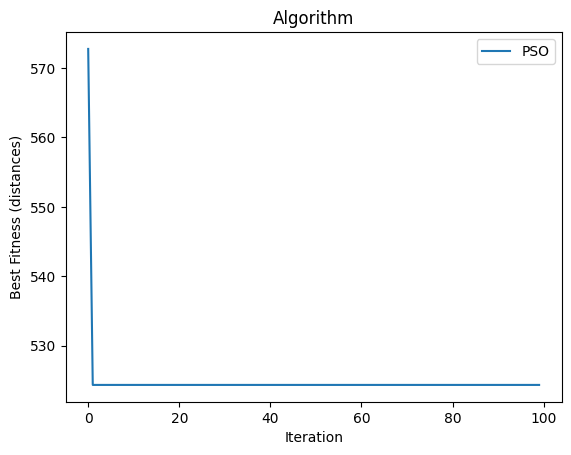

In [114]:
plt.plot(fitness_history,label = 'PSO')
plt.title('Algorithm')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (distances)')
plt.legend()
plt.show()

In [35]:
class ACO:
    def __init__(self, cities, num_salesmen, num_ants, evaporation_rate, alpha, beta, iterations):
        self.cities = np.array(cities)[:, 1:]
        self.depot = self.cities[0]  
        self.num_cities = len(self.cities)
        self.num_salesmen = num_salesmen
        self.pheromones = np.ones((self.num_cities, self.num_cities))
        self.num_ants = num_ants
        self.evaporation_rate = evaporation_rate
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def distance(self, city1, city2):
        return np.linalg.norm(city1 - city2)


    def construct_routes(self):
        all_routes = []
        all_route_lengths = []

        for ant in range(self.num_ants):
            routes = [[] for _ in range(self.num_salesmen)]  
            remaining_cities = set(range(1, self.num_cities))  

            while remaining_cities:
                for route in routes:
                    if not remaining_cities:
                        break
                    current_city = route[-1] if route else 0  # If the route is empty, start from the starting point
                    probabilities = self.calculate_probabilities(current_city, remaining_cities)
                    next_city = np.random.choice(list(remaining_cities), p=probabilities)
                    route.append(next_city)
                    remaining_cities.remove(next_city)

            
            for route in routes:
                route.append(0)  # Go back to starting point

            all_routes.append(routes)
            all_route_lengths.append(self.calculate_total_route_length(routes))

        return all_routes, all_route_lengths

    def calculate_probabilities(self, current_city, remaining_cities):
        probabilities = []
        total = 0
        for next_city in remaining_cities:
            tau = self.pheromones[current_city][next_city] ** self.alpha
            eta = (1 / self.distance(self.cities[current_city], self.cities[next_city])) ** self.beta
            probability = tau * eta
            probabilities.append(probability)
            total += probability

        return [p / total for p in probabilities]


    def calculate_total_route_length(self, routes):
        total_length = 0
        for route in routes:
            for i in range(len(route)-1):
                route_length = self.distance(self.cities[route[i]], self.cities[route[i + 1]])
                total_length += route_length
        return total_length

    def update_pheromones(self, all_routes, all_route_lengths):
        self.pheromones *= (1 - self.evaporation_rate)
        for routes, total_length in zip(all_routes, all_route_lengths):
            for route in routes:
                for i in range(len(route) - 1):
                    self.pheromones[route[i]][route[i + 1]] += 1 / total_length

    def run(self):
        best_distance = float('inf')
        best_routes = None
        fitness_history = []

        for iteration in range(self.iterations):
            all_routes, all_route_lengths = self.construct_routes()
            self.update_pheromones(all_routes, all_route_lengths)

            total_route_length = min(all_route_lengths)
            if total_route_length < best_distance:
                best_distance = total_route_length
                best_routes = all_routes[all_route_lengths.index(total_route_length)]
            fitness_history.append(best_distance)

        return best_routes, best_distance, fitness_history


In [20]:
num_salesmen=3
num_ants=30
evaporation_rate=0.5
alpha=1
beta=1.5
iterations=100
aco = ACO(cities, num_salesmen, num_ants, evaporation_rate, alpha, beta, iterations)
best_routes, best_distance, fitness_history = aco.run()

In [123]:
num_salesmen=3
num_ants=30
evaporation_rate=0.5
alpha=1
beta=1.5
iterations=100
aco = ACO(cities, num_salesmen, num_ants, evaporation_rate, alpha, beta, iterations)
best_routes, best_distance, fitness_history = aco.run()
best_distance

511.14709592569324

In [149]:
num_salesmen=3
num_ants=30
evaporation_rate=0.5
alpha=1
beta=1.5
iterations=100
aco = ACO(cities, num_salesmen, num_ants, evaporation_rate, alpha, beta, iterations)
best_routes, best_distance, fitness_history = aco.run()
best_distance

508.06952315616604

In [21]:
best_distance

523.9472842435289

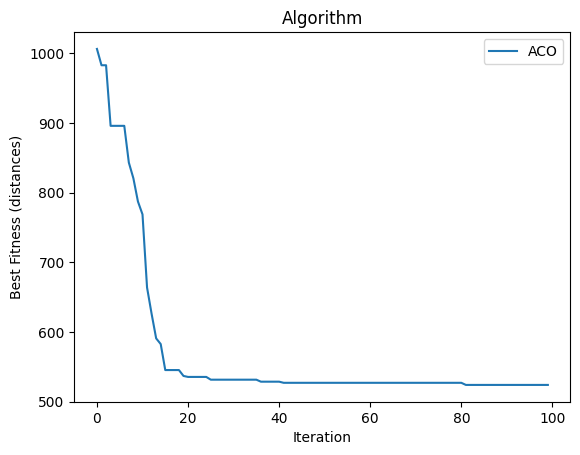

In [22]:
plt.plot(fitness_history,label = 'ACO')
plt.title('Algorithm')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (distances)')
plt.legend()
plt.show()

In [20]:
class MTSPTabuSearch:
    def __init__(self, customers, distances, demands, depots, capacity, num_salesmen, max_iterations=20):
        self.customers = customers
        self.distances = distances
        self.demands = demands
        self.depots = depots
        self.capacity = capacity
        self.num_salesmen = num_salesmen
        self.n = len(customers)
        self.max_iterations = max_iterations
        self.tabu_list = [([0] * self.n) for i in range(self.n)]
        self.tab_length = int(self.n // 5)
        self.best_solution = self.initial_solution(mode='random')
        self.best_distance = self.calculate_distance(self.best_solution)
        self.fitness_history = []

    def initial_solution(self, mode="random"):
        # 使用贪婪算法或其他方法生成初始解
        # ...
        solution = []
        unvisited = list(item[0] for item in self.customers)
        unvisited.remove(self.depots[0])
        count = len(unvisited)
        solution.append(self.depots[0])
        while(count!=0):
            index = random.randint(0, count - 1)
            current = unvisited[index]
            solution.append(current)
            unvisited.remove(current)
            count -= 1
        solution.append(self.depots[0])
        return solution

    def generate_neighborhood(self, solution):
        # 生成邻居
        # ...
        for i in range(1, len(solution) - 1):  # 不包括仓库
            for j in range(i + 1, len(solution) - 1):  # 不包括仓库
                if i != j:
                    neighbor = solution[:]  # 复制解    
                    # 交换两个节点的位置
                    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                    yield neighbor, (i, j)

    def calculate_distance(self, solution):
        # 计算解的总距离
        total_distance = 0.0
        num_customers_per_salesman = (len(self.customers)-1) // self.num_salesmen
        for i in range(self.num_salesmen):
            start = i * num_customers_per_salesman
            end = (i + 1) * num_customers_per_salesman if i != self.num_salesmen - 1 else len(self.customers)
            total_distance += self.distances[self.depots[0] - 1][solution[start] - 1]
            for j in range(start, end - 1):
                total_distance += self.distances[solution[j] - 1][solution[j + 1] - 1]
            total_distance += self.distances[solution[end - 1] - 1][self.depots[0] - 1]
        return total_distance

    def update_tabu_list(self, move):
        # 更新禁忌列表
        # ...
        for i in range(self.n):
            for j in range(self.n-i):
                if self.tabu_list[i][j] != 0:
                    self.tabu_list[i][j] -= 1
        self.tabu_list[move[0]][move[1]] = self.tab_length

    def is_tabu(self, move):
        # 判断操作是否在禁忌列表中
        # ...
        return self.tabu_list[move[0]][move[1]] != 0

    def search(self):
        for _ in range(self.max_iterations):
            neighborhood = self.generate_neighborhood(self.best_solution)
            for neighbor, move in neighborhood:
                if not self.is_tabu(move):
                    distance = self.calculate_distance(neighbor)
                    if distance < self.best_distance:
                        self.best_solution = neighbor
                        self.best_distance = distance
                        self.update_tabu_list(move)
                # self.fitness_history.append(self.best_distance)
            self.fitness_history.append(self.best_distance)
        return self.best_solution, self.best_distance, self.fitness_history

In [21]:
# ts = MTSPTabuSearch(cities, distances, demands, depots, capacity, 3, 40)
ts = MTSPTabuSearch(cities, distances, demands, depots, capacity, 3, 1000)
best_solution, best_distance, fitness_history = ts.search()

In [22]:
best_distance

606.9073089839152

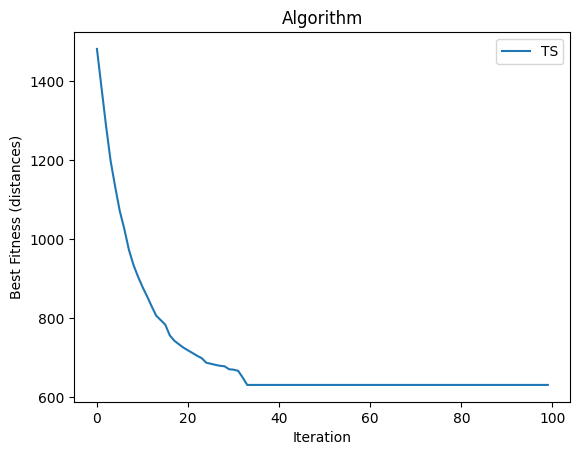

In [98]:
ts = MTSPTabuSearch(cities, distances, demands, depots, capacity, 3, 100)
best_solution, best_distance, fitness_history = ts.search()
plt.plot(fitness_history,label = 'TS')
plt.title('Algorithm')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (distances)')
plt.legend()
plt.show()

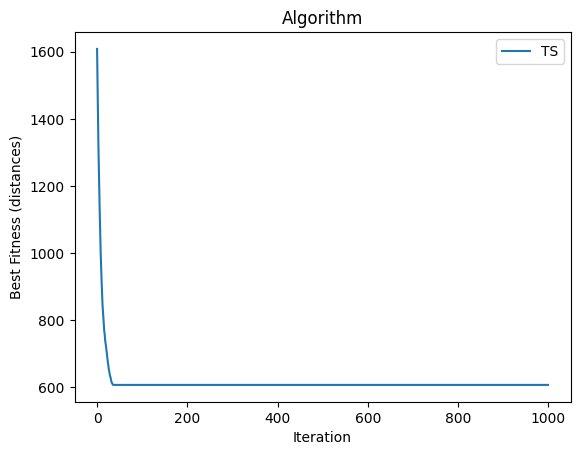

In [23]:
# Plot the convergence curve
plt.plot(fitness_history,label = 'TS')
plt.title('Algorithm')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (distances)')
plt.legend()
plt.show()

In [14]:
class MTSPSimulatedAnnealing:
    def __init__(self, customers, distances, demands, depots, capacity, num_salesmen, max_iterations=1000, alpha=0.9, initial_temp=100):
        self.customers = customers
        self.distances = distances
        self.demands = demands
        self.depots = depots
        self.capacity = capacity
        self.num_salesmen = num_salesmen
        self.n = len(customers)
        self.max_iterations = max_iterations
        self.alpha = alpha
        self.initial_temp = initial_temp
        self.best_solution = self.initial_solution(mode='random')
        self.best_distance = self.calculate_distance(self.best_solution)
        self.fitness_history = []

    def initial_solution(self, mode="random"):
        # 使用贪婪算法或其他方法生成初始解
        # ...
        solution = []
        unvisited = list(item[0] for item in self.customers)
        unvisited.remove(self.depots[0])
        count = len(unvisited)
        solution.append(self.depots[0])
        while(count!=0):
            index = random.randint(0, count - 1)
            current = unvisited[index]
            solution.append(current)
            unvisited.remove(current)
            count -= 1
        solution.append(self.depots[0])
        return solution

    def generate_neighborhood(self, solution):
        # 生成邻居
        # ...
        for i in range(1, len(solution) - 1):  # 不包括仓库
            for j in range(i + 1, len(solution) - 1):  # 不包括仓库
                if i != j:
                    neighbor = solution[:]  # 复制解    
                    # 交换两个节点的位置
                    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                    yield neighbor, (i, j)

    def calculate_distance(self, solution):
        # 计算解的总距离
        total_distance = 0.0
        num_customers_per_salesman = len(self.customers) // self.num_salesmen
        for i in range(self.num_salesmen):
            start = i * num_customers_per_salesman
            end = (i + 1) * num_customers_per_salesman if i != self.num_salesmen - 1 else len(self.customers)
            total_distance += self.distances[self.depots[0] - 1][solution[start] - 1]
            for j in range(start, end - 1):
                total_distance += self.distances[solution[j] - 1][solution[j + 1] - 1]
            total_distance += self.distances[solution[end - 1] - 1][self.depots[0] - 1]
        return total_distance

    def acceptance_probability(self, old_cost, new_cost, temp):
        return math.exp((old_cost - new_cost) / temp)

    def anneal(self):
        current_solution = self.best_solution
        current_cost = self.best_distance
        temp = self.initial_temp

        for i in range(self.max_iterations):
            neighborhood = list(self.generate_neighborhood(current_solution))
            neighbor, move = random.choice(neighborhood)
            neighbor_cost = self.calculate_distance(neighbor)
            if neighbor_cost < current_cost or random.random() < self.acceptance_probability(current_cost, neighbor_cost, temp):
                current_solution = neighbor
                current_cost = neighbor_cost
            temp *= self.alpha
            self.fitness_history.append(current_cost)

        return current_solution, current_cost, self.fitness_history

In [18]:
sa = MTSPSimulatedAnnealing(cities, distances, demands, depots, capacity, 3, max_iterations=1000, alpha=0.99, initial_temp=1000)
best_solution, best_distance, fitness_history = sa.anneal()

In [186]:
sa = MTSPSimulatedAnnealing(cities, distances, demands, depots, capacity, 3, max_iterations=10000, alpha=0.995, initial_temp=1000)
best_solution, best_distance, fitness_history = sa.anneal()
best_distance

620.9478569865311

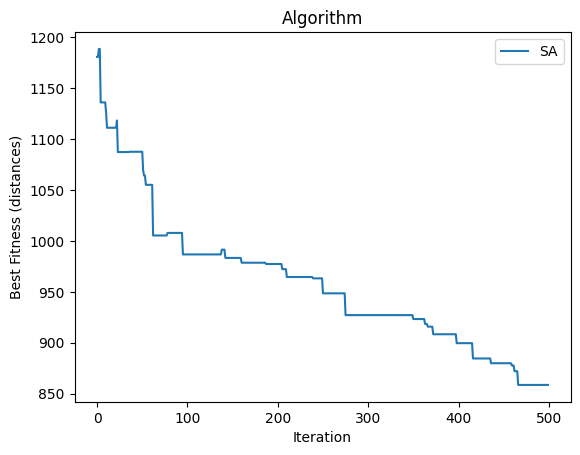

In [97]:
sa = MTSPSimulatedAnnealing(cities, distances, demands, depots, capacity, 3, max_iterations=1000, alpha=0.99, initial_temp=1000)
best_solution, best_distance, fitness_history = sa.anneal()
plt.plot(fitness_history[500:],label = 'SA')
plt.title('Algorithm')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (distances)')
plt.legend()
plt.show()

In [19]:
best_distance

791.3248604638138

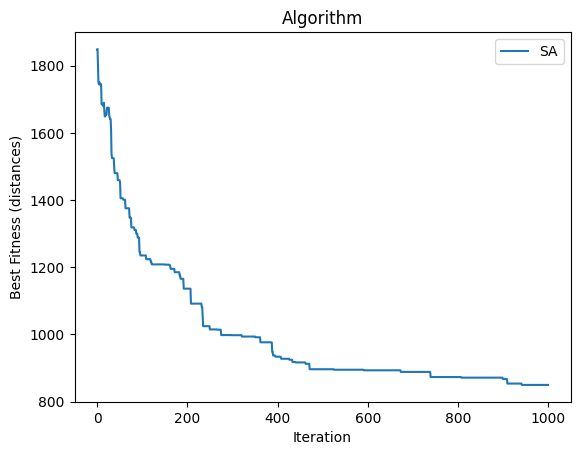

In [30]:
# Plot the convergence curve
plt.plot(fitness_history,label = 'SA')
plt.title('Algorithm')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (distances)')
plt.legend()
plt.show()